In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# va por aca che
def make_timeline(sf, bw, spc):
    # sf: spreading factor
    # bw: bandwidth
    # spc: samples per chip
    symbol_time = (2**sf) / bw
    timeline =  np.linspace(0, symbol_time, (2**sf) * spc + 1)
    timeline = timeline[:-1]
    return timeline

In [4]:
def make_freq_evol(symbol, timeline, sf, bw):
    # bw: bandwidth
    theoretical_symbol_time = (2**sf) / bw
    slope = bw / (theoretical_symbol_time)
    y_intercept = symbol * (bw / 2**sf)
    frequency_evolution = []
    for i in range(len(timeline)):
        instant_freq = y_intercept + slope * timeline[i]
        if instant_freq > bw:
            instant_freq = instant_freq - bw
        frequency_evolution.append(instant_freq)
    
    return frequency_evolution

In [5]:
def compute_auxiliary_phase_factor(symbol, timeline, sf, bw):
    # bw: bandwidth
    theoretical_symbol_time = (2**sf) / bw
    slope = bw / (theoretical_symbol_time)
    y_intercept = symbol * (bw / 2**sf)
    integrated_freq = []
    for i in range(len(timeline)):
        instant_freq = y_intercept + 0.5 * slope * timeline[i]
        if instant_freq > bw:
            instant_freq = instant_freq - bw
        integrated_freq.append(instant_freq)
    
    return integrated_freq

In [6]:
def generate_signal(sf, freq, timeline, samples_per_symbol = 1):
    # sf: spreading factor
    # freq: frequency
    # timeline: timeline
    coeff = 1/(np.sqrt(2**sf * samples_per_symbol) )
    signal = []

    for i in range(len(timeline)):

        inst_phase = 2 * np.pi * freq[i] * timeline[i] 
        signal.append( coeff * np.exp(1j * inst_phase) )

    return signal

In [7]:
## Demodulation
# Generate downchirp
def generate_downchirp(sf, bw, timeline, also_return_freq=False, samples_per_chip = 1):
    # sf: spreading factor
    # freq: frequency
    # timeline: timeline
    y_intercept = bw
    theoretical_symbol_time = (2**sf) / bw
    freqs = []
    integrated_freqs = []
    slope = -bw / theoretical_symbol_time
    coeff = 1/(np.sqrt(2**sf * samples_per_chip) )
    signal = []

    for i in range(len(timeline)):
        freq = y_intercept + slope * timeline[i]
        integrated_freq = y_intercept + 0.5 * slope * timeline[i]

        inst_phase = 2 * np.pi * (integrated_freq) * timeline[i]
        signal.append( coeff * np.exp(1j * inst_phase))
        freqs.append(freq)
        

    if also_return_freq:
        return signal, freqs
    return signal

def correlate(signal, sf, downchirp, return_symbol=False):
    product = []
    for i in range(len(signal)):
        product.append(signal[i] * downchirp[i])

    fourier_transform = np.fft.fft(product)
    
    if return_symbol:
        return np.argmax(fourier_transform)
    
    return fourier_transform

In [8]:
def test_all(sf, bw, spc):
    symbols_sent = []
    symbols_received = []
    timeline_2 = make_timeline(sf, bw, spc)
    error_started_at = -1
    for i in range(2**sf):
        freq = make_freq_evol(i, timeline_2, sf, bw)
        signal = generate_signal(sf, freq, timeline_2)
        downchirp = generate_downchirp(sf, bw, timeline_2)
        correlation = correlate(signal,sf, downchirp, return_symbol=True)
        symbols_sent.append(i)
        symbols_received.append(correlation)
        if error_started_at == -1 and i != correlation:
            error_started_at = i
    return symbols_sent, symbols_received, error_started_at


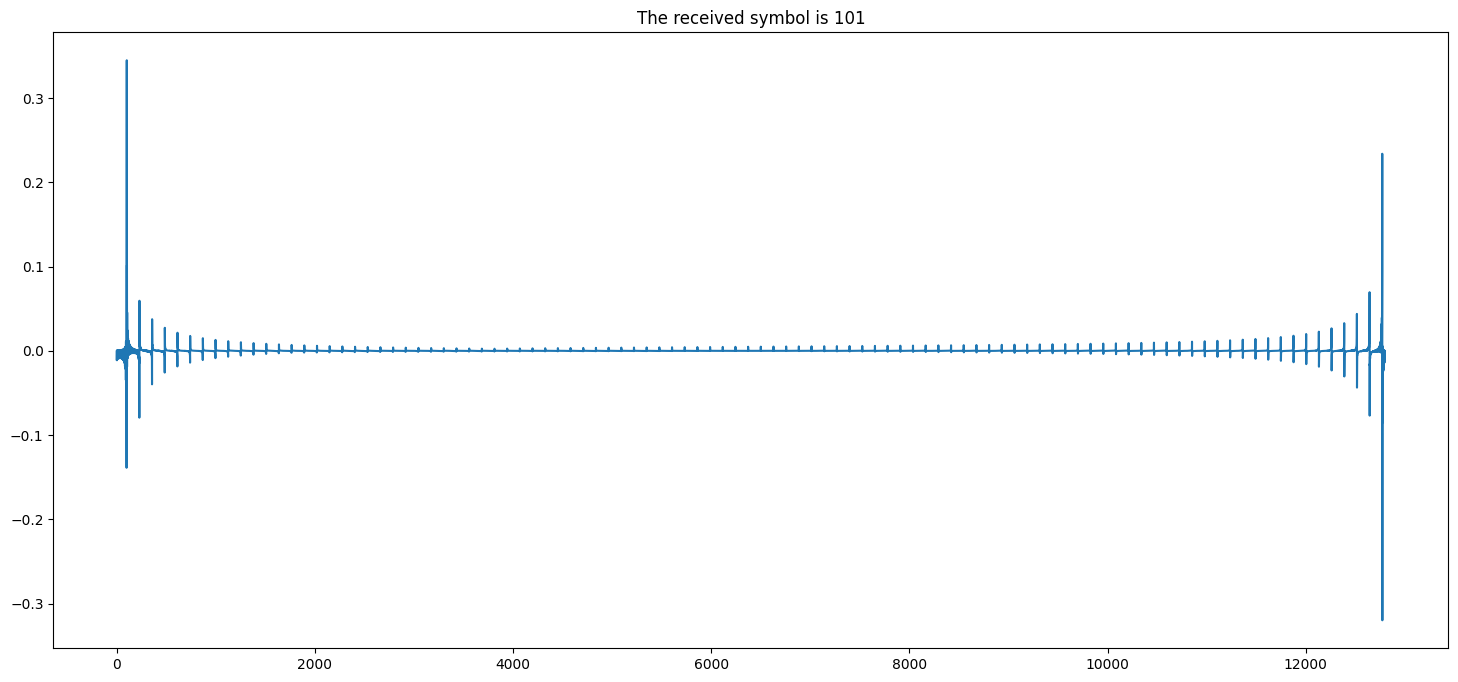

In [19]:
symbol = 100
sf, bw, spc = 7, 125000, 100
time = make_timeline(7, 125000, spc)
freq = make_freq_evol(symbol, time, sf, bw)
int_freq = compute_auxiliary_phase_factor(symbol, time, sf, bw)
int_freq = int_freq[::spc]
int_freq = np.repeat(int_freq, spc)
signal = generate_signal(sf, int_freq, time, spc)
downchirp = generate_downchirp(sf, bw, time, samples_per_chip=spc)
downchirp = downchirp[::spc]
downchirp = np.repeat(downchirp, spc)

correlation = correlate(signal, sf, downchirp)
plt.figure(figsize=(18, 8))
plt.title('The received symbol is ' + str(np.argmax(correlation)))
plt.plot(correlation)



In [10]:
def test_all(sf, bw, spc):
    t = make_timeline(sf, bw, spc)
    symbols_sent = []  
    symbols_received = []

    for i in range(2**sf):
        freq = make_freq_evol(i, t, sf, bw)
        int_freq = compute_auxiliary_phase_factor(i, t, sf, bw)
        if spc > 1:
            freq = freq[::spc]
            freq = np.repeat(freq, spc)

        signal = generate_signal(sf, int_freq, t)

        downchirp = generate_downchirp(sf, bw, t)
        if spc > 1:
            downchirp = downchirp[::spc]
            downchirp = np.repeat(downchirp, spc)
        correlation = correlate(signal,sf, downchirp, return_symbol=True)
        symbols_sent.append(i)
        symbols_received.append(correlation)
    return symbols_sent, symbols_received

In [11]:
def test_all(sf, bw, t):

    symbols_sent = []
    symbols_received = []
    for i in range(2**sf):
        freq = make_freq_evol(i, t, sf, bw)
        int_freq = compute_auxiliary_phase_factor(i, t, sf, bw)
        int_freq = int_freq[::10]
        signal = generate_signal(sf, int_freq, t)

        downchirp = generate_downchirp(sf, bw, t)
        correlation = correlate(signal,sf, downchirp, return_symbol=True)
        symbols_sent.append(i)
        symbols_received.append(correlation)
    return symbols_sent, symbols_received

spreading_factor = 7
bandwidth = 125e3
samples_per_chip = 1
timeline = make_timeline(spreading_factor, bandwidth, samples_per_chip)
symbols_sent, symbols_received = test_all(spreading_factor, bandwidth, timeline)
plt.figure(figsize=(20,8))
plt.plot(symbols_sent, label="Sent")
plt.plot(symbols_received,'o', label="Received")
if symbols_sent == symbols_received:
    plt.title("Correct demodulation")





IndexError: list index out of range

In [ ]:
def signal_power(signal):
    # Calculate the signal power
    P = np.mean(np.abs(signal)**2)
    return P


def noise_generator(SNR, w):
    # Check if SNR is given in dB, DB, or db and convert if necessary
    if isinstance(SNR, str) and SNR.lower().endswith('db'):
        # Extract the numeric part and convert from dB to linear scale
        SNR_value = float(SNR[:-2])  # Remove the last two characters and convert to float
        SNR_linear = 10 ** (SNR_value / 10)
    else:
        # Assume SNR is already in linear scale
        SNR_linear = SNR
    
    # Determine the noise power (variance)
    variance = signal_power(w) / SNR_linear
    std_dev = variance ** 0.5
    # Generate noise
    N = [np.random.normal(0, std_dev) + np.random.normal(0, std_dev)*1j for _ in w]
    noisy_signal = [w[i] + N[i] for i in range(len(w))]
    return noisy_signal, N, variance